In [111]:
import numpy as np
import nibabel as nib
from nibabel.affines import apply_affine
import os
import pandas as pd


In [ ]:
# Get all surface files all in one directory
surf_dir = 'raw_data/FreeSurfer_Surfaces/40_depths'
surf_files = sorted([f for f in os.listdir(surf_dir) if f.startswith('rh.equi')])

print(f"{len(surf_files)} surface files")
depths = len(surf_files)

# array to store every vertex coordinate
all_vertex_coords = []
# array of tuples to store each vertex unique identifier (vertex_id, depth)
all_vertex_labels = []

for depth_idx, surf_filename in enumerate(surf_files):
    surf_file = os.path.join(surf_dir, surf_filename)
    
    #print(f"Depth {depth_idx}: {surf_filename}")
    
    coords, faces, volume_info = nib.freesurfer.read_geometry(surf_file, read_metadata=True)
    cras = np.array(volume_info['cras'])
    scanner_ras = coords + cras
    
    all_vertex_coords.append(scanner_ras)
    
    labels = [(v_id, depth_idx) for v_id in range(len(coords))]
    all_vertex_labels.extend(labels)

all_vertex_coords = np.vstack(all_vertex_coords)

print(f"\nTotal vertices: {len(all_vertex_coords):,}")
print(f"Shape: {all_vertex_coords.shape}")
print(f"length of all_vertex_labels: {len(all_vertex_labels)}")

41 surface files

Total vertices: 10,222,489
Shape: (10222489, 3)
length of all_vertex_labels: 10222489


In [ ]:
# Load volume
volume = nib.load('raw_data/RHoccip_SGcrop.nii.gz')
print(f"Volume shape: {volume.shape}")
print(f"Total voxels: {np.prod(volume.shape):,}")

# Create grid of voxel indices
i, j, k = np.meshgrid(
    np.arange(volume.shape[0]),
    np.arange(volume.shape[1]),
    np.arange(volume.shape[2]),
    indexing='ij'
)

voxel_indices = np.column_stack([i.reshape(-1), j.reshape(-1), k.reshape(-1)])
print(f"Voxel indices shape: {voxel_indices.shape}")

# Transform to Scanner RAS using volume's affine
voxel_ras = apply_affine(volume.affine, voxel_indices)
print(f"Voxel RAS coordinates shape: {voxel_ras.shape}")

# Get intensities
intensities = volume.get_fdata().reshape(-1)
print(f"Intensities shape: {intensities.shape}")

Volume shape: (182, 274, 305)
Total voxels: 15,209,740
Voxel indices shape: (15209740, 3)
Voxel RAS coordinates shape: (15209740, 3)
Intensities shape: (15209740,)


In [114]:
SGmask = nib.load('raw_data/SG_mask_100um_extra_labels.nii.gz')
print(f"Volume Shape: {SGmask.shape}")
SGlabels = SGmask.get_fdata().reshape(-1)
print(f"labels shape: {SGlabels.shape}")



Volume Shape: (182, 274, 305)
labels shape: (15209740,)


In [ ]:
from scipy.spatial import cKDTree

# Build KD tree from vertex coordinates in mm scanner ras
vertex_tree = cKDTree(all_vertex_coords)

print(f"Tree points: {vertex_tree.n}")

print(f"Voxels to query: {len(voxel_ras)}")

# Find nearest vertex for each voxel
distances, nearest_vertex_global_idx = vertex_tree.query(voxel_ras, k=1)

print(f"nearest_vertex_global_idx shape: {nearest_vertex_global_idx.shape}")

Tree points: 10222489
Voxels to query: 15209740
nearest_vertex_global_idx shape: (15209740,)


In [116]:
# Extract vertex_id and depth from global indices
all_vertex_labels_array = np.array(all_vertex_labels)
voxel_vertex_ids = all_vertex_labels_array[nearest_vertex_global_idx, 0]
voxel_depths = all_vertex_labels_array[nearest_vertex_global_idx, 1]

# create table
df = pd.DataFrame({
    'vertex_id': voxel_vertex_ids,
    'depth': voxel_depths,
    'intensity': intensities,
    'label': SGlabels
})

# Resolve SGlabels per vertex
def resolve_label(SGlabels):
    nonzero = SGlabels[SGlabels != 0]
    if len(nonzero) == 0:
        return 0
    if set(nonzero) == {1, 2}:  # Conflict
        return 1 if (nonzero == 1).sum() > (nonzero == 2).sum() else 2
    return int(nonzero.iloc[0])

vertex_labels_series = df.groupby('vertex_id')['label'].agg(resolve_label)

# Build profiles
profiles = df.groupby(['vertex_id', 'depth'])['intensity'].median().unstack()

# Combine
profiles['label'] = profiles.index.map(vertex_labels_series).fillna(0).astype(int)

print(profiles.head())

depth           0   1   2   3   4   5   6   7   8   9  ...  32  33  34  35  \
vertex_id                                              ...                   
525        3411.5 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
540        4267.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
584         552.5 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
585         565.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
598        1125.5 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   

depth      36  37  38  39  40  label  
vertex_id                             
525       NaN NaN NaN NaN NaN      0  
540       NaN NaN NaN NaN NaN      0  
584       NaN NaN NaN NaN NaN      0  
585       NaN NaN NaN NaN NaN      0  
598       NaN NaN NaN NaN NaN      0  

[5 rows x 42 columns]


In [117]:
print(len(df))

15209740


Total labeled profiles: 5144
  SG (label=1): 2963
  Non-SG (label=2): 2181


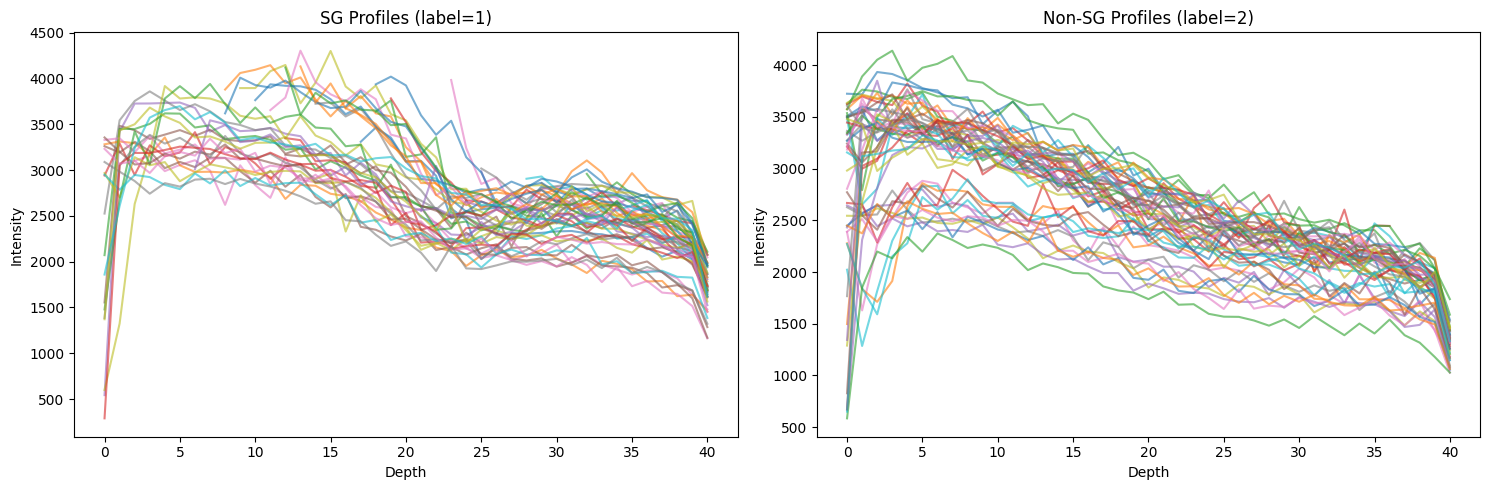

In [133]:
import matplotlib.pyplot as plt

# Get labeled profiles
labeled_profiles = profiles[profiles['label'] != 0].copy()

print(f"Total labeled profiles: {len(labeled_profiles)}")
print(f"  SG (label=1): {(labeled_profiles['label'] == 1).sum()}")
print(f"  Non-SG (label=2): {(labeled_profiles['label'] == 2).sum()}")

# Plot first 20 SG profiles
sg_profiles = labeled_profiles[labeled_profiles['label'] == 1]
depth_cols = list(range(41))  # Depths 0-40

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# SG profiles
for i, (vertex_id, row) in enumerate(sg_profiles.head(50).iterrows()):
    intensities = row[depth_cols].values
    ax1.plot(intensities, alpha=0.6, label=f'v{vertex_id}')
ax1.set_title('SG Profiles (label=1)')
ax1.set_xlabel('Depth')
ax1.set_ylabel('Intensity')

# Non-SG profiles
non_sg_profiles = labeled_profiles[labeled_profiles['label'] == 2]
for i, (vertex_id, row) in enumerate(non_sg_profiles.head(50).iterrows()):
    intensities = row[depth_cols].values
    ax2.plot(intensities, alpha=0.6, label=f'v{vertex_id}')
ax2.set_title('Non-SG Profiles (label=2)')
ax2.set_xlabel('Depth')
ax2.set_ylabel('Intensity')

plt.tight_layout()
plt.show()

In [ ]:

# Extract middle depths (6-34) artefacts at boundaries and not important
middle_depths = list(range(6, 35))

# Create feature_df
feature_df = profiles[middle_depths].copy()
feature_df.insert(0, 'col_id', profiles.index)  # Add vertex_id as 'col_id' column

# Remove vertices with NaN in middle depths
n_before = len(feature_df)
feature_df = feature_df.dropna(subset=middle_depths)
n_after = len(feature_df)

print(f"before: {n_before} after: {n_after}")

# Create label dict
label_dict = profiles['label'].to_dict()

# add label column to features
feature_df['label'] = feature_df['col_id'].map(profiles['label']).fillna(0)

# Filter out label=0 (unlabelled in the mask)
feature_df_labeled = feature_df[feature_df['label'] != 0].copy()

print(f"\nLabeled vertices: {len(feature_df_labeled)}")
print(f"  SG: {(feature_df_labeled['label'] == 1).sum()}")
print(f"  Non-SG: {(feature_df_labeled['label'] == 2).sum()}")

# Create label_dict from labeled data only
label_dict_filtered = feature_df_labeled.set_index('col_id')['label'].to_dict()


Vertices before filtering: 11640
Vertices after filtering: 9456
Removed 2184 vertices with incomplete profiles

Labeled vertices: 4859
  SG (1): 2858
  Non-SG (2): 2001


In [120]:
# Train with raw intensities
from src.classifier_training import prepare_training_data, train_rf_model, evaluate_model

X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_training_data(
    feature_df_labeled.drop('label', axis=1), 
    label_dict_filtered, 
    features_to_use=middle_depths  # Use raw intensities as features
)

rf_model = train_rf_model(X_train_scaled, y_train)
preds, probs = evaluate_model(rf_model, X_test_scaled, y_test, model_name='rf')


Evaluation for rf
              precision    recall  f1-score   support

           1       0.88      0.77      0.82      1157
           2       0.72      0.85      0.78       787

    accuracy                           0.80      1944
   macro avg       0.80      0.81      0.80      1944
weighted avg       0.82      0.80      0.81      1944

rf ROC-AUC: 0.876


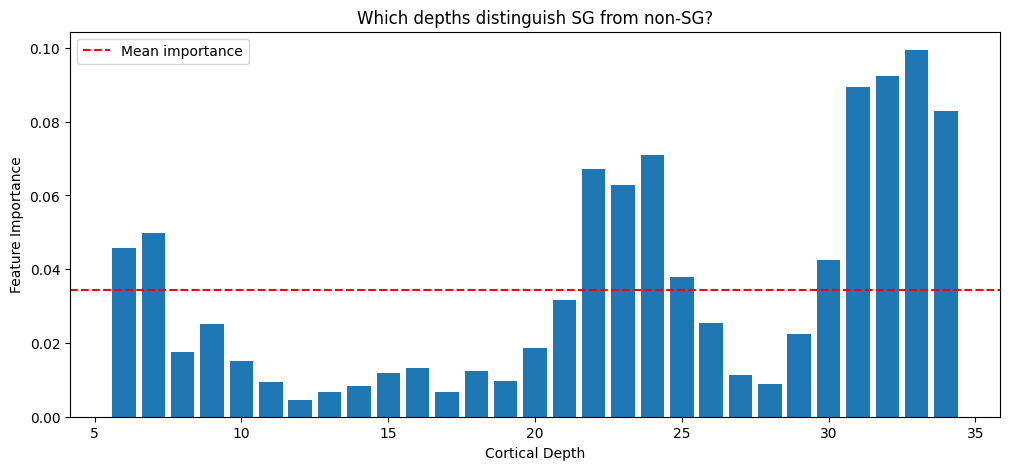

In [121]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_model.feature_importances_
depths = middle_depths

plt.figure(figsize=(12, 5))
plt.bar(depths, importances)
plt.xlabel('Cortical Depth')
plt.ylabel('Feature Importance')
plt.title('Which depths distinguish SG from non-SG?')
plt.axhline(y=np.mean(importances), color='r', linestyle='--', label='Mean importance')
plt.legend()
plt.show()

In [ ]:
from src.extract_features import compute_features

# profiles df to dict for compute_features
def dataframe_to_profile_dict(df, depth_columns):
    profiles_dict = {}
    for idx, row in df.iterrows():
        vertex_id = row['col_id']
        depths = np.array(depth_columns)
        intensities = row[depth_columns].values
        profiles_dict[vertex_id] = (depths, intensities)
    return profiles_dict

# extract features
vertex_profiles = dataframe_to_profile_dict(feature_df_labeled, middle_depths)
feature_df_eng = compute_features(vertex_profiles, threshold_factor=0.03) 



In [ ]:
# Add labels and filter
feature_df_eng['label'] = feature_df_eng['col_id'].map(label_dict_filtered)


print(f"Profiles with features: {len(feature_df_eng)}")


Profiles with features: 4859


In [ ]:

# train with extracted features
feature_columns = ['dip_width', 'dip_depth_diff', 'post_dip_ratio', 'second_derivative_max']

X_train_eng, X_test_eng, y_train_eng, y_test_eng, scaler_eng = prepare_training_data(
    feature_df_eng.drop('label', axis=1),
    feature_df_eng.set_index('col_id')['label'].to_dict(),
    features_to_use=feature_columns
)

rf_model_eng = train_rf_model(X_train_eng, y_train_eng)
preds_eng, probs_eng = evaluate_model(rf_model_eng, X_test_eng, y_test_eng, model_name='rf_eng')


Evaluation for rf_eng
              precision    recall  f1-score   support

           1       0.90      0.65      0.76      1157
           2       0.64      0.89      0.74       787

    accuracy                           0.75      1944
   macro avg       0.77      0.77      0.75      1944
weighted avg       0.79      0.75      0.75      1944

rf_eng ROC-AUC: 0.846


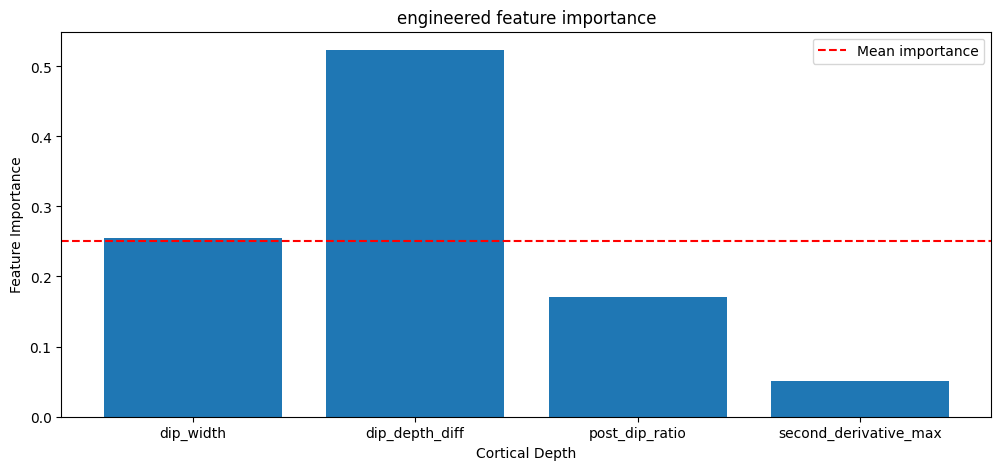

In [ ]:
import matplotlib.pyplot as plt

# feature importances
importances = rf_model_eng.feature_importances_ 


plt.figure(figsize=(12, 5))
plt.bar(feature_columns, importances)
plt.xlabel('Cortical Depth')
plt.ylabel('Feature Importance')
plt.title('engineered feature importance')
plt.axhline(y=np.mean(importances), color='r', linestyle='--', label='Mean importance')
plt.legend()
plt.show()